# Amazon SageMaker JumpStart Image editing - Stable Diffusion Inpainting

---
Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)에 오신 것을 환영합니다! Sagemaker JumpStart이용하면 SageMaker Studio에서 원클릭으로, 또는[SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/overview.html#use-prebuilt-models-with-sagemaker-jumpstart)를 통해 다양한 머신러닝 작업을 해결할 수 있습니다..

이 데모 노트북에서는 세이지메이커 파이썬 SDK를 사용하여 사전 학습된 최신 안정 확산 모델로 이미지를 인페인팅하는 방법을 보여드립니다. 인페인팅은 이미지의 일부를 텍스트 프롬프트에 설명된 다른 이미지로 대체하는 작업입니다.  원본 이미지, 마스크 이미지(대체할 부분을 설명하는 이미지), 텍스트 프롬프트가 주어지면 안정적 확산 모델은 텍스트 프롬프트에 설명된 물체/피사체/환경으로 마스크된 부분을 대체하는 새로운 이미지를 생성합니다. 

---

1. [Set Up](#1.-Set-Up)
2. [Select a model](#2.-Select-a-model)
3. [Retrieve JumpStart Artifacts & Deploy an Endpoint](#3.-Retrieve-JumpStart-Artifacts-&-Deploy-an-Endpoint)
4. [Query endpoint and parse response](#4.-Query-endpoint-and-parse-response)
5. [Clean up the endpoint](#5.-Clean-up-the-endpoint)

참고: 이 노트북은 Python 3 (Data Science 2.0) 커널이 포함된 Amazon SageMaker Studio의 ml.t3.medium 인스턴스와 conda_python3 커널이 포함된 Amazon SageMaker Notebook 인스턴스에서 테스트되었습니다.

참고: 노트북 실행을 완료한 후에는 모든 리소스를 삭제하여 프로세스에서 생성한 모든 리소스가 삭제되고 청구가 중지되도록 하세요. [Clean up the endpoint](#5.-Clean-up-the-endpoint)의 코드는 생성된 모델과 엔드포인트를 삭제합니다.

### 1. Set Up

---
노트북을 실행하기 전에 설정에 필요한 몇 가지 초기 단계가 있습니다. 이 노트북을 사용하려면 ipywidgets와 최신 버전의 sagemaker가 필요합니다.

---

In [2]:
!pip install ipywidgets==7.0.0 --quiet
!pip install --upgrade sagemaker

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.9/916.9 kB 12.6 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for urllib3<1.27,>=1.25.4 from https://files.pythonhosted.org/packa

#### 권한 및 환경 변수

---
Amazon SageMaker에서 호스팅하려면 AWS 서비스 사용을 설정하고 인증해야 합니다. 여기서는 현재 노트북과 연결된 실행 역할을 SageMaker 액세스 권한이 있는 AWS 계정 역할로 사용합니다. 

---

In [3]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


### 2. Select a model

***
본 모델을 계속 사용하거나 다음 셀을 실행할 때 생성되는 드롭다운에서 다른 모델을 선택할 수 있습니다. SageMaker 사전 학습 모델의 전체 목록은 [Sagemaker pre-trained Models](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html#)에서도 확인할 수 있습니다.
***

In [5]:
model_id, model_version = "model-inpainting-stabilityai-stable-diffusion-2-inpainting-fp16", "*"

***
[Optional] 여기서는 모든 인페인팅 모델을 필터링하고 추론할 모델을 선택합니다.
***

In [6]:
from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models

# 모든 텍스트-이미지 생성 모델을 검색합니다.
filter_value = "task == inpainting"
inpainting_models = list_jumpstart_models(filter=filter_value)

# 드롭다운에 모델 ID를 표시하여 추론할 모델을 선택할 수 있습니다.
model_dropdown = Dropdown(
    options=inpainting_models,
    value=model_id,
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)

#### Chose a model for Inference

In [7]:
display(model_dropdown)

A Jupyter Widget

In [8]:
# model_version="*" 모델의 최신 버전을 가져옵니다.
model_id, model_version = model_dropdown.value, "*"

### 3. Retrieve Artifacts & Deploy an Endpoint

***

SageMaker를 사용하면 새로운 데이터 세트에서 먼저 미세 조정하지 않고도 사전 학습된 모델에 대해 추론을 수행할 수 있습니다. 먼저 사전 학습된 모델에 대한 `deploy_image_uri`와 `model_uri`를 검색합니다. 사전 학습된 모델을 호스팅하기 위해, [`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html)의 인스턴스를 생성하고 배포합니다. 기본 `model_id`의 경우 최대 10분 정도 소요될 수 있습니다.

***

In [9]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-{model_id}")

# GPU 메모리가 더 많은 인스턴스는 더 큰 이미지 생성을 지원합니다.
# 따라서 매우 큰 이미지를 생성하려면 ml.g5.2xlarge와 같은 인스턴스 유형을 선택하세요.
inference_instance_type = "ml.p3.2xlarge"

# 추론 도커 컨테이너 uri를 검색합니다. 위의 기본 모델에 대한 기본 HuggingFace 컨테이너 이미지입니다.
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # model_id에서 자동 추론
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# 모델 URI를 검색합니다. 여기에는 사전 학습된 모델과 매개변수, 추론 스크립트가 포함됩니다.
# 여기에는 모델 로드, 추론 처리 등을 위한 모든 종속성 및 스크립트가 포함됩니다.
model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)

# SageMaker 모델 인스턴스 생성
model = Model(
    image_uri=deploy_image_uri,
    model_data=model_uri,
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)

# 모델을 배포합니다. 모델 클래스를 통해 모델을 배포할 때 Predictor 클래스를 전달해야 SageMaker API를 통해 추론을 실행할 수 있다는 점에 유의하세요.
model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
--------------!

### 4. Query endpoint and parse response

---
엔드포인트에 대한 입력은 이미지, 마스크, 프롬프트, 이미지 생성 매개변수이며 `utf-8` 형식으로 인코딩된 json 형식입니다. 엔드포인트의 출력은 생성된 이미지가 포함된 `json` 딕셔너리입니다.

---

#### 예제 이미지 확인
---
먼저 예제 이미지와 마스크 이미지를 확인합니다.

---

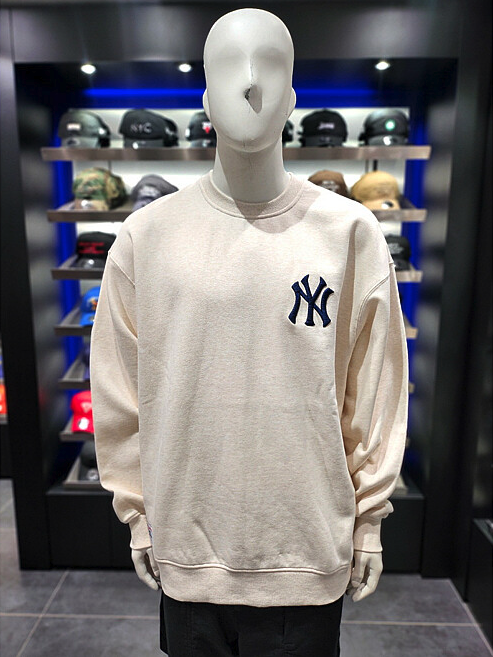

In [57]:
from IPython.display import Image

input_img_file_name = "./data/1_product.png"

# 원본 이미지 표시
Image(filename=input_img_file_name, width=632, height=632)

#### 마스크

***
마스크는 교체할 부분은 모두 흰색이고 상수인 부분은 모두 검은색으로 표시된 이미지입니다. 

***

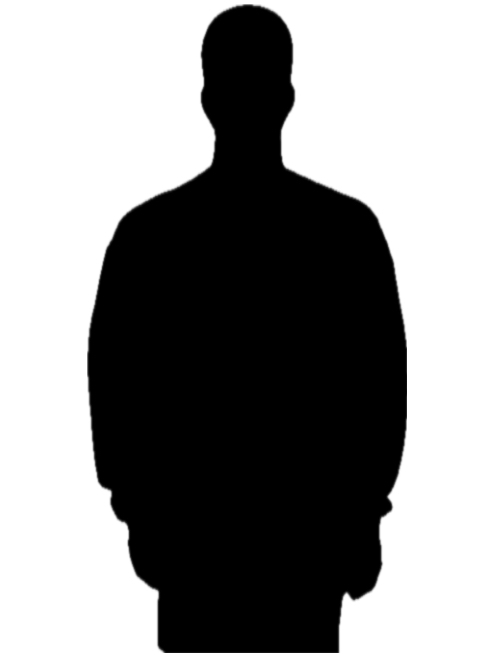

In [58]:
# 피사체를 구분하는 마스크 이미지

input_img_mask_file_name = "./data/1_product_mask.png"

Image(filename=input_img_mask_file_name, width=632, height=632)

다음으로 엔드포인트를 쿼리하고, 응답을 구문 분석하고, 생성된 이미지를 표시하기 위한 helper 함수를 작성합니다.

In [59]:
import matplotlib.pyplot as plt
import numpy as np


def query(model_predictor, payload, content_type, accept):
    """Query the model predictor."""

    query_response = model_predictor.predict(
        payload,
        {
            "ContentType": content_type,
            "Accept": accept,
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return the generated images."""

    response_dict = json.loads(query_response)
    return response_dict["generated_images"]


def display_img_and_prompt(img, prmpt):
    """Display the generated image."""
    plt.figure(figsize=(12, 12))
    plt.imshow(np.array(img))
    plt.axis("off")
    plt.title(prmpt)
    plt.show()

#### 예시 - 배경 변경하기

---
아래는 예제 이미지, 마스크, 프롬프트를 입력한 것입니다. 어떤 이미지, 마스크, 프롬프트를 입력해도 모델이 해당 이미지에 해당하는 색칠된 이미지를 생성합니다. 

---

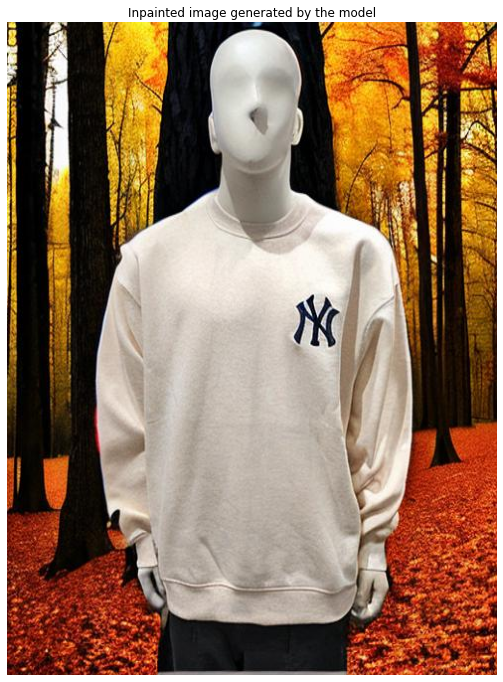

In [83]:
text = "In the Autumn Forest"


negative_prompts = [
    "poorly rendered",
    "poor background",
]


import base64
from PIL import Image
from io import BytesIO


# content_type = 'application/json;jpeg'인 경우, 엔드포인트는 페이로드가 원본 이미지와 마스크 이미지가 base64.b64 인코딩으로 인코딩된 바이트 단위의 json일 것으로 기대합니다.
# 원본 이미지를 엔드포인트로 전송하려면, content_type = 'application/json', encoded_image를 np.array(PIL.Image.open(input_img_file_name.jpg)).tolist()로 설정하면 됩니다.
content_type = "application/json;jpeg"


with open(input_img_file_name, "rb") as f:
    input_img_image_bytes = f.read()
with open(input_img_mask_file_name, "rb") as f:
    input_img_mask_image_bytes = f.read()

encoded_input_image = base64.b64encode(bytearray(input_img_image_bytes)).decode()
encoded_mask = base64.b64encode(bytearray(input_img_mask_image_bytes)).decode()


payload = {
    "prompt": text,
    "image": encoded_input_image,
    "mask_image": encoded_mask,
    "num_inference_steps": 90,
    "guidance_scale": 20,
    "seed": 6,
    "negative_prompt": negative_prompts,
}


# accept = 'application/json;jpeg'의 경우, 엔드포인트는 base64.b64 인코딩으로 인코딩된 바이트 단위로 jpeg 이미지를 반환합니다.
# RGB 값으로 설정된 원시 이미지를 받으려면 Accept = 'application/json'
accept = "application/json;jpeg"

# 원시/rgb 값으로 페이로드를 보내거나 받으면 입력 페이로드 및 응답 크기에 대한 기본 제한에 도달할 수 있다는 점에 유의하세요.

query_response = query(model_predictor, json.dumps(payload).encode("utf-8"), content_type, accept)
generated_images = parse_response(query_response)


# 위에서 언급한 accept = 'application/json;jpeg'의 경우 반환된 이미지는 base64.b64 인코딩으로 인코딩된 바이트 단위의 jpeg입니다.
# 여기서는 이미지를 디코딩하고 이미지를 표시합니다.
for generated_image in generated_images:
    generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
    generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")
    # 생성된 이미지는 generated_image_rgb.save('inpainted_image.jpg')를 호출하여 저장할 수 있습니다.
    display_img_and_prompt(generated_image_rgb, "Inpainted image generated by the model")

---

#### 다른 예시

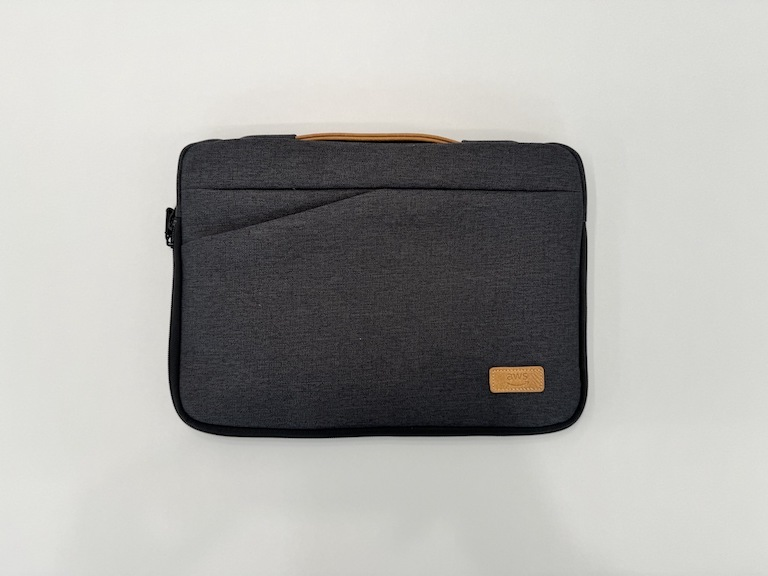

In [32]:
from IPython.display import Image

input_img_file_name = "./data/2_product.jpg"

Image(filename=input_img_file_name, width=632, height=632)

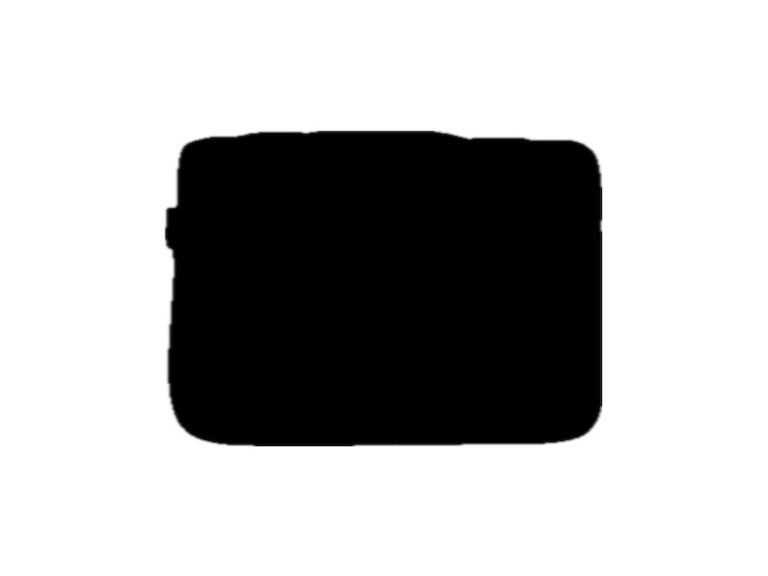

In [33]:
input_img_mask_file_name = "./data/2_product_mask2.jpg"

Image(filename=input_img_mask_file_name, width=632, height=632)

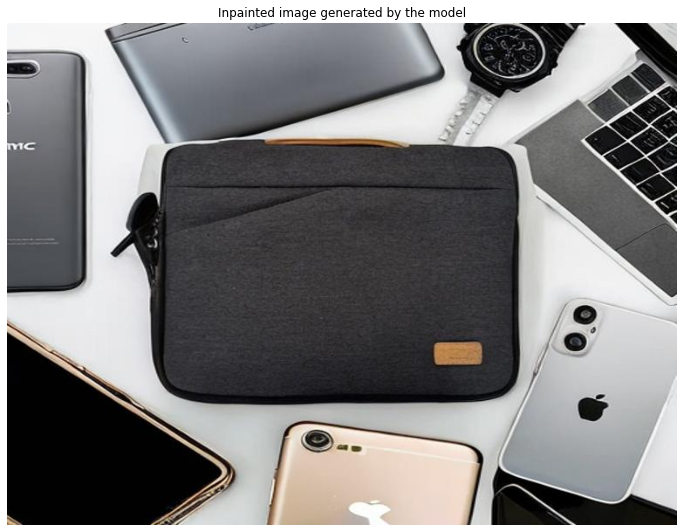

In [56]:
text = "a bag is surrounded by mobile phones and laptops"

negative_prompts = [
    "poorly rendered",
    "poor background",
]


import base64
from PIL import Image
from io import BytesIO


content_type = "application/json;jpeg"

with open(input_img_file_name, "rb") as f:
    input_img_image_bytes = f.read()
with open(input_img_mask_file_name, "rb") as f:
    input_img_mask_image_bytes = f.read()

encoded_input_image = base64.b64encode(bytearray(input_img_image_bytes)).decode()
encoded_mask = base64.b64encode(bytearray(input_img_mask_image_bytes)).decode()


payload = {
    "prompt": text,
    "image": encoded_input_image,
    "mask_image": encoded_mask,
    "num_inference_steps": 60,
    "guidance_scale": 9,
    #"seed": 1,
    "negative_prompt": negative_prompts,
}


accept = "application/json;jpeg"

query_response = query(model_predictor, json.dumps(payload).encode("utf-8"), content_type, accept)
generated_images = parse_response(query_response)


for generated_image in generated_images:
    generated_image_decoded = BytesIO(base64.b64decode(generated_image.encode()))
    generated_image_rgb = Image.open(generated_image_decoded).convert("RGB")

    display_img_and_prompt(generated_image_rgb, "Inpainted image generated by the model")

#### Supported Parameters

***
이 모델은 추론을 수행하는 동안 많은 매개 변수를 지원합니다. 여기에는 다음이 포함됩니다:

* **prompt**: 프롬프트에 이미지 생성을 안내합니다. 반드시 지정해야 하며 문자열 또는 문자열 목록일 수 있습니다.
* **num_inference_steps**: 이미지 생성 중 노이즈 제거 단계 수입니다. 단계가 많을수록 이미지 품질이 높아집니다. 지정하는 경우 양수여야 합니다.
* **guidance_scale**: 안내 척도가 높을수록 이미지 품질은 떨어지지만 프롬프트와 밀접하게 관련된 이미지가 생성됩니다. 지정하는 경우 반드시 실수여야 합니다. guidance_scale<=1은 무시됩니다.
* **negative_prompt**: 이 프롬프트에 대한 가이드 이미지 생성을 지정합니다. 지정하는 경우 문자열 또는 문자열 목록이어야 하며 guidance_scale과 함께 사용해야 합니다. guidance_scale이 비활성화되면 이 옵션도 비활성화됩니다. 또한 프롬프트가 문자열 목록인 경우 negative_prompt도 문자열 목록이어야 합니다.
* **num_images_per_prompt**: 프롬프트당 반환되는 이미지 수입니다. 지정하는 경우 양수여야 합니다.
* **seed**: 재현성을 위해 무작위 상태를 수정합니다. 지정하는 경우 정수여야 합니다.
* **batch_size**: 단일 포워드 패스에서 생성할 이미지 수입니다. 더 작은 인스턴스를 사용하거나 많은 이미지를 생성하는 경우 batch_size를 작은 숫자(1-2)로 줄이세요. Number of images = number of prompts*num_images_per_prompt.

***

### 5. Clean up the endpoint

In [ ]:
# Delete the SageMaker endpoint

#model_predictor.delete_model()
#model_predictor.delete_endpoint()

### Conclusion

***
이 튜토리얼에서는 JumpStart를 사용하여 사전 학습된 Stable Diffusion 인페인팅 모델을 SageMaker에 배포하는 방법을 배웠습니다. Stable Diffusion 모델은 이미지의 일부를 대체하고 매우 사실적인 이미지를 생성하는 데 매우 효과적이라는 것을 확인했습니다. Jumpstart는 인페인팅을 위해 Stable Diffusion 1과 Stable Diffusion 2 및 해당 FP16 개정판을 모두 제공합니다. 

추론 중에 적절한 매개변수를 선택하여 이미지 생성 프로세스를 조정할 수 있습니다. 이러한 매개변수를 설정하는 방법에 대한 지침은 지원되는 추론 매개변수 섹션에서 확인할 수 있습니다. 

***

